# From Standard Directory Structures

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Download the dataset

In [0]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip 'hymenoptera_data.zip'    
os.remove('hymenoptera_data.zip')

--2019-06-22 10:32:35--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.29.60, 13.224.29.48, 13.224.29.19, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.29.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  63.2MB/s    in 0.7s    

2019-06-22 10:32:36 (63.2 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/tr

In [0]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=20),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

# datasets are defined for both train and val
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),image_transforms['train'])
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),image_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4) 
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=4) 

In [0]:
images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)

print(train_dataset.classes)
print(len(train_dataset))

torch.Size([4, 3, 224, 224])
torch.Size([4])
['ants', 'bees']
244


# From Filenames
For this we need to define our own dataset

PyTorch gives you the freedom to pretty much do anything with the Dataset class so long as you override two of the subclass functions:

* the __len__ function which returns the size of the dataset, and
* the __getitem__ function which returns a sample from the dataset given an index.
### Defining a simple dataset
This dataset stores number between a range 

In [0]:
from torch.utils.data import Dataset

class NumbersDataset(Dataset):
    
    def __init__(self, low, high):
        # create the dataset in the constructor  
        self.samples = list(range(low, high))

    def __len__(self):
        # returns the length of the dataset
        return len(self.samples)

    def __getitem__(self, idx):
        # returns an item at the given index
        return self.samples[idx]

In [0]:
dataset = NumbersDataset(0, 1000)

print(len(dataset))
print(dataset[100])
print(dataset[122:361])

1000
100
[122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 

### Download Dogs vs Cats dataset from Kaggle
You must accept the rules before downloading the dataset

In [0]:
!pip install kaggle

### Go to my account on Kaggle website and generate new API token ###
### API token will be downloaded as kaggle.json file ###

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()

import kaggle

Saving kaggle.json to kaggle.json


 #### Download data from Kaggle and unzip the files of interest. 

In [0]:
import zipfile

# This function will extract the desired zip files in the dataset
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

# This function will download the necessary files from the dataset and use the above function to unzip them    
def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'test1.zip')  

# You must accept the competition rules before downloading
competition_name = 'dogs-vs-cats'

# Download the dataset    
get_data(competition_name)

## Define a dataset to read images from filenames

In [0]:
class dataset_from_filenames(Dataset):
    
    def __init__(self,root_dir, transforms):
        
        self.image_filenames = []
        self.labels = []
        self.transforms = transforms
        
        for filename in os.listdir(root_dir):
            self.image_filenames.append(os.path.join(root_dir,filename))
            
            if filename.startswith('cat'):
                self.labels.append(0)
            elif filename.startswith('dog'):
                self.labels.append(1)
    
    # You must override __getitem__ and __len__
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self,index):
        image = Image.open(self.image_filenames[index])
        image = self.transforms(image)  
        return image, self.labels[index]    

In [0]:
# define the transformations
image_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=20),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


25000
Number of cats: 12500
Number of dogs: 12500
torch.Size([3, 224, 224])
Label: 1


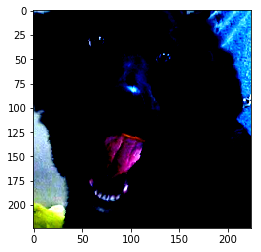

In [0]:
train_dataset = dataset_from_filenames('dogs-vs-cats/train', image_transforms)

print(len(train_dataset))
print('Number of cats: {}'.format(train_dataset.labels.count(0)))
print('Number of dogs: {}'.format(train_dataset.labels.count(1)))

image, label = train_dataset[0]
print(image.shape)
print('Label: {}'.format(label.numpy()))

plt.imshow(image.numpy().transpose(1,2,0))